In [ ]:
# Librerías
import numpy as np
import pandas as pd
from geopy.distance import geodesic
import random
import matplotlib.pyplot as plt



Parámetros (ubicación inicial en el centro de mty)

In [ ]:

center_lat, center_lon = 25.68, -100.32
radius_km = 15
num_sucursales = 500
num_proveedores = 3
num_centros = 10
costo_km = 1
num_configuraciones = 100



Planteamiento inicial

In [ ]:
# Coordenadas
def generar_coordenadas_en_circulo(centro, radio_km, n, en_borde=False):
    coords = []
    for _ in range(n):
        angulo = np.random.uniform(0, 2 * np.pi)
        distancia = radio_km if en_borde else np.random.uniform(0, radio_km)
        delta_lat = (distancia / 111) * np.cos(angulo)
        delta_lon = (distancia / (111 * np.cos(np.radians(centro[0])))) * np.sin(angulo)
        lat = centro[0] + delta_lat
        lon = centro[1] + delta_lon
        coords.append((lat, lon))
    return coords

# Función de distancia y costo
def calcular_costo(proveedor, centro, sucursal):
    dist_pc = geodesic(proveedor, centro).km
    dist_cs = geodesic(centro, sucursal).km
    return (dist_pc + dist_cs) * costo_km



GRAPS + Taboo search

In [ ]:
# Algoritmo GRASP + Tabú
def grasp_tabu_optimizacion(df_suc, df_prov, iteraciones=100, vecinos=20):
    mejor_solucion = None
    mejor_costo = float('inf')
    mejor_centros = None

    for _ in range(iteraciones):
        centros = generar_coordenadas_en_circulo((center_lat, center_lon), radius_km, num_centros)
        df_centros = pd.DataFrame(centros, columns=["lat", "lon"])
        asignacion = []

        for i, suc in df_suc.iterrows():
            costos = []
            for j, centro in df_centros.iterrows():
                proveedor = df_prov.sample(1).iloc[0]
                costo = calcular_costo(
                    (proveedor['lat'], proveedor['lon']),
                    (centro['lat'], centro['lon']),
                    (suc['lat'], suc['lon'])
                )
                costos.append((costo, j, proveedor))
            costos.sort()
            costo_sel, idx_centro, proveedor_sel = random.choice(costos[:3])
            asignacion.append((i, idx_centro, proveedor_sel, costo_sel))

        costo_total = sum([x[3] for x in asignacion])
        tabu_list = []

        for _ in range(vecinos):
            nuevo_idx = random.randint(0, len(asignacion) - 1)
            suc_id, _, _, _ = asignacion[nuevo_idx]
            nuevos_costos = []

            for j, centro in df_centros.iterrows():
                proveedor = df_prov.sample(1).iloc[0]
                suc = df_suc.iloc[suc_id]
                costo = calcular_costo(
                    (proveedor['lat'], proveedor['lon']),
                    (centro['lat'], centro['lon']),
                    (suc['lat'], suc['lon'])
                )
                nuevos_costos.append((costo, j, proveedor))
            nuevos_costos.sort()

            for nuevo in nuevos_costos:
                if (suc_id, nuevo[1]) not in tabu_list:
                    asignacion[nuevo_idx] = (suc_id, nuevo[1], nuevo[2], nuevo[0])
                    tabu_list.append((suc_id, nuevo[1]))
                    if len(tabu_list) > 100:
                        tabu_list.pop(0)
                    break

            nuevo_costo_total = sum([x[3] for x in asignacion])
            if nuevo_costo_total < costo_total:
                costo_total = nuevo_costo_total

        if costo_total < mejor_costo:
            mejor_costo = costo_total
            mejor_solucion = asignacion
            mejor_centros = df_centros.copy()

    return mejor_solucion, mejor_centros, mejor_costo



Datos (tiempo aprox 4:20 mins)

In [ ]:
# Iniciales
sucursales = generar_coordenadas_en_circulo((center_lat, center_lon), radius_km, num_sucursales)
proveedores = generar_coordenadas_en_circulo((center_lat, center_lon), radius_km, num_proveedores, en_borde=True)
demandas = np.random.randint(1, 6, size=num_sucursales)

df_sucursales = pd.DataFrame(sucursales, columns=["lat", "lon"])
df_sucursales["demanda"] = demandas

df_proveedores = pd.DataFrame(proveedores, columns=["lat", "lon"])

# Optimización
solucion, centros_finales, costo_final = grasp_tabu_optimizacion(df_sucursales, df_proveedores)



Resumen

In [ ]:
# Resumen
resumen = []
for i, centro_id, proveedor, costo in solucion:
    suc = df_sucursales.iloc[i]
    centro = centros_finales.iloc[centro_id]
    resumen.append({
        "Sucursal_ID": i,
        "Centro_ID": centro_id,
        "Proveedor_Lat": proveedor['lat'],
        "Proveedor_Lon": proveedor['lon'],
        "Centro_Lat": centro['lat'],
        "Centro_Lon": centro['lon'],
        "Sucursal_Lat": suc['lat'],
        "Sucursal_Lon": suc['lon'],
        "Demanda": suc['demanda'],
        "Costo": costo
    })

df_resumen = pd.DataFrame(resumen)

# Datos adicionales
demanda_por_centro = df_resumen.groupby("Centro_ID")["Demanda"].sum().reset_index()
demanda_por_centro.columns = ["Centro_ID", "Demanda_Total"]

sucursales_por_centro = df_resumen.groupby("Centro_ID")["Sucursal_ID"].count().reset_index()
sucursales_por_centro.columns = ["Centro_ID", "Num_Sucursales"]

costo_por_centro = df_resumen.groupby("Centro_ID")["Costo"].sum().reset_index()
costo_por_centro.columns = ["Centro_ID", "Costo_Total"]

resumen_centros = demanda_por_centro.merge(sucursales_por_centro, on="Centro_ID").merge(costo_por_centro, on="Centro_ID")



Gráficos

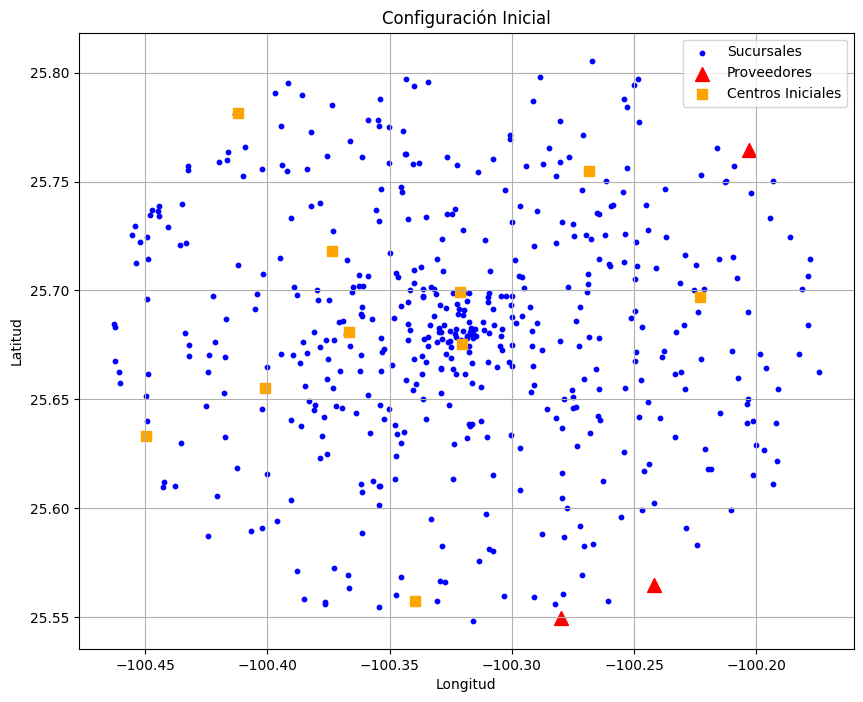

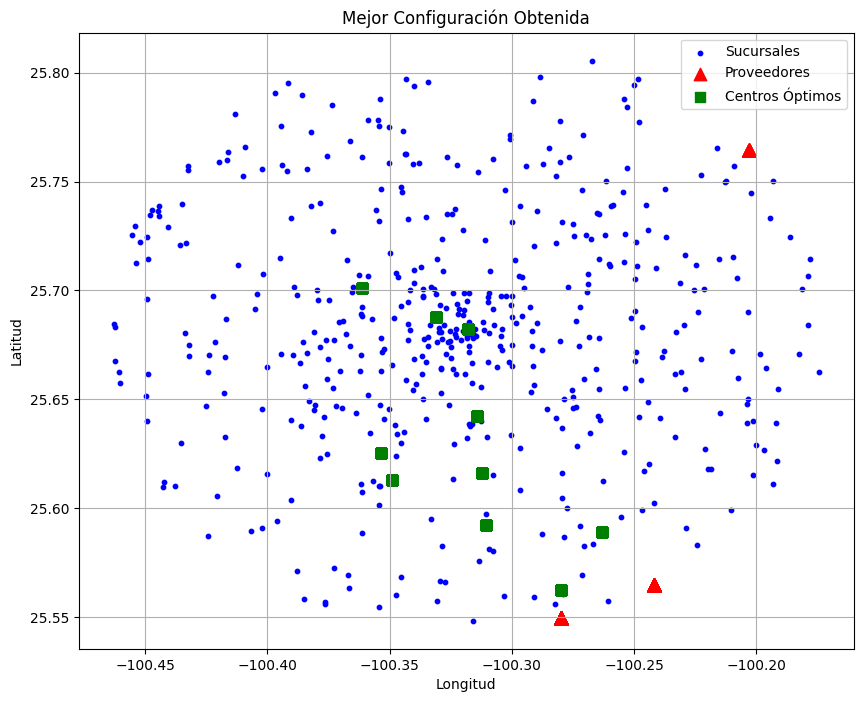

Resumen por Centro de Distribución:

   Centro_ID  Demanda_Total  Num_Sucursales  Costo_Total
0          0           76.0              25   489.101572
1          1           70.0              22   451.786119
2          2          210.0              72  1322.433244
3          3          237.0              78  1293.624233
4          4          107.0              33   593.001892
5          5          228.0              75  1152.687982
6          6          192.0              60  1156.848921
7          7          172.0              60  1049.678996
8          8           48.0              17   403.036560
9          9          160.0              58  1187.206024

Costo total mínimo estimado: 9099.41


In [ ]:
# Visualización
def visualizar_ubicaciones_iniciales():
    df_centros_ini = pd.DataFrame(generar_coordenadas_en_circulo((center_lat, center_lon), radius_km, num_centros), columns=["lat", "lon"])
    plt.figure(figsize=(10, 8))
    plt.scatter(df_sucursales["lon"], df_sucursales["lat"], c='blue', s=10, label='Sucursales')
    plt.scatter(df_proveedores["lon"], df_proveedores["lat"], c='red', s=100, marker='^', label='Proveedores')
    plt.scatter(df_centros_ini["lon"], df_centros_ini["lat"], c='orange', s=60, marker='s', label='Centros Iniciales')
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.title("Configuración Inicial")
    plt.legend()
    plt.grid(True)
    plt.show()

def visualizar_solucion(df_resumen):
    plt.figure(figsize=(10, 8))
    plt.scatter(df_resumen["Sucursal_Lon"], df_resumen["Sucursal_Lat"], c='blue', s=10, label='Sucursales')
    plt.scatter(df_resumen["Proveedor_Lon"], df_resumen["Proveedor_Lat"], c='red', s=80, marker='^', label='Proveedores')
    plt.scatter(df_resumen["Centro_Lon"], df_resumen["Centro_Lat"], c='green', s=60, marker='s', label='Centros Óptimos')
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.title("Mejor Configuración Obtenida")
    plt.legend()
    plt.grid(True)
    plt.show()

visualizar_ubicaciones_iniciales()
visualizar_solucion(df_resumen)
print("Resumen por Centro de Distribución:\n")
print(resumen_centros)
print(f"\nCosto total mínimo estimado: {costo_final:.2f}")